![Cloud-First](../image/CloudFirst.png)


# SIT742: Modern Data Science
**(Module: Big Data Manipulation)**

---
- Materials in this module include resources collected from various open-source online repositories.
- You are free to use, change and distribute this package.
- If you found any issue/bug for this document, please submit an issue at [tulip-lab/sit742](https://github.com/tulip-lab/sit742/issues)


Prepared by **SIT742 Teaching Team**

---


## Session 5F: Advanced Time Series Forecasting
---

### Table of Content

Part A: Data Exploration and Temporal Feature Set Up

1. Download and Preprocess Data

2. Prepare Dataset for LSTM

3. Define LSTM with Attention
4. Train the Model
5. Make Predictions (Ex-post) and Evaluation

Part B: Attension Score Exploration

6. Construct the Attention Mechanism

7. Plot the Averaged Attention Score

---

## Introduction ##

This notebook demonstrates how to build a advanced time series forecasting model for stock prices using an LSTM with an attention mechanism. It walks through downloading and preprocessing historical Apple stock data, preparing the dataset for the model, defining and training the LSTM-Attention network, and evaluating the predictions. Additionally, it visualizes the model’s attention scores to interpret which input features (Open, High, Low prices) the model focuses on when making forecasts. This example provides a practical introduction to combining deep learning and attention mechanisms for time series prediction.

# Part A: Data Exploration and Temporal Feature Set Up

In [1]:
import yfinance as yf
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

## 1: Download and Preprocess Data

In [2]:
aapl_data = yf.download('AAPL', start='2020-01-01', end='2023-01-01')
close_prices = aapl_data[['Open','High','Low']].values
scaler = MinMaxScaler(feature_range=(0, 1))
close_prices_scaled = scaler.fit_transform(close_prices)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


## 2: Prepare Dataset for LSTM
Data Preparation:
**Input (X):**

`X = close_prices_scaled[:-1]:`
Uses all but the last row of normalized stock data (Open, High, Low).

**Target (y):**

`y = close_prices_scaled[1:, 2]:`
Uses the Low price from the next day (column index 2) as the target.

**Reshape for LSTM:**

`X = X.reshape(X.shape[0], 3, 1):`

**Reshapes X into 3D format:**
(samples, sequence_length=3, features=1)

Each input sequence contains 3 time steps (Open, High, Low).

`y = y.reshape(-1, 1):`

Flattens the target into a column vector of shape (samples, 1).

**Train-Test Split:**

`train_test_split(..., test_size=0.2, random_state=42):`

Splits the dataset into 80% training and 20% testing.

**Convert to PyTorch Tensors:**

`torch.tensor(..., dtype=torch.float32):`

Converts all datasets (X_train, X_test, y_train, y_test) to PyTorch tensors required for model training. *italicised text*

In [3]:
X = close_prices_scaled[:-1]
y = close_prices_scaled[1:, 2]
X = X.reshape(X.shape[0], 3, 1)
y = y.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

## 3: Define LSTM with Attention

*This module defines an LSTM model enhanced with an attention mechanism for sequence modeling. It initializes an LSTM layer that processes input sequences and outputs hidden states. The attention mechanism learns to assign importance weights to each timestep by passing the LSTM outputs through a linear layer followed by a softmax, creating a probability distribution over timesteps. These attention weights are then used to compute a weighted sum of the LSTM outputs, producing a context vector that highlights the most relevant information from the sequence. Finally, this context vector is fed through a fully connected layer to generate the output prediction. The forward method optionally returns the attention weights alongside the output for interpretability.*

In [4]:
class LSTMAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1, num_layers=1):
        super(LSTMAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.attention = nn.Linear(hidden_dim, 1)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, return_attention=False):
        lstm_out, _ = self.lstm(x)
        attention_weights = torch.softmax(self.attention(lstm_out).squeeze(-1), dim=-1)
        context_vector = torch.sum(lstm_out * attention_weights.unsqueeze(-1), dim=1)
        out = self.fc(context_vector)
        if return_attention:
            return out, attention_weights
        return out

## 4: Train the Model

In [5]:
model = LSTMAttention(input_dim=1, hidden_dim=50)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = criterion(output, y_train_tensor)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        model.eval()
        test_pred = model(X_test_tensor)
        test_loss = criterion(test_pred, y_test_tensor)
        print(f'Epoch {epoch}, Loss: {loss.item()}, Test Loss: {test_loss.item()}')

Epoch 0, Loss: 0.36984893679618835, Test Loss: 0.28987568616867065
Epoch 10, Loss: 0.041991036385297775, Test Loss: 0.0404924675822258
Epoch 20, Loss: 0.029588621109724045, Test Loss: 0.031834591180086136
Epoch 30, Loss: 0.01996428519487381, Test Loss: 0.022890480235219002
Epoch 40, Loss: 0.010159257799386978, Test Loss: 0.010312431491911411
Epoch 50, Loss: 0.001009672530926764, Test Loss: 0.001394954277202487
Epoch 60, Loss: 0.0019267193274572492, Test Loss: 0.0014251774409785867
Epoch 70, Loss: 0.0007363053737208247, Test Loss: 0.0008518834947608411
Epoch 80, Loss: 0.000760550145059824, Test Loss: 0.0008804855169728398
Epoch 90, Loss: 0.000611575786024332, Test Loss: 0.0006757726659998298


## 5: Make Predictions (Ex-post)

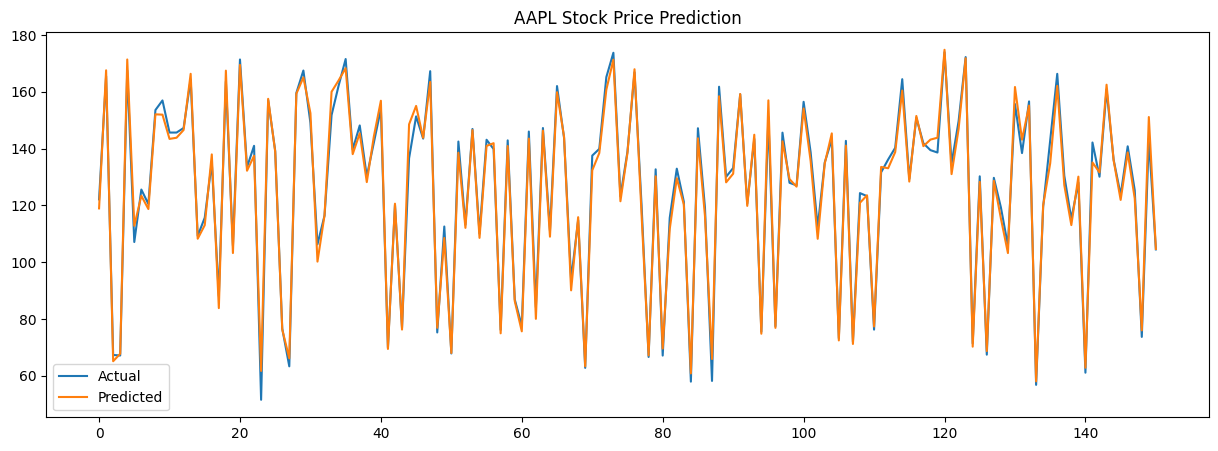

In [6]:
model.eval()
predictions = model(X_test_tensor).detach().numpy()
predictions_actual = scaler.inverse_transform(np.hstack((np.zeros_like(predictions), np.zeros_like(predictions), predictions)))[:, 2:]

plt.figure(figsize=(15, 5))
plt.plot(scaler.inverse_transform(np.hstack((np.zeros_like(y_test), np.zeros_like(y_test), y_test)))[:, 2:], label='Actual')
plt.plot(predictions_actual, label='Predicted')
plt.title('AAPL Stock Price Prediction')
plt.legend()
plt.show()

## 6: Calculate Performance

In [7]:
mse = mean_squared_error(scaler.inverse_transform(np.hstack((np.zeros_like(y_test), np.zeros_like(y_test), y_test)))[:, 2:], predictions_actual)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 9.874681957915454


# Part B: Attension Score Exploration

## 1: Construct with Attention Mechanism

In [8]:
all_attention_weights = []
with torch.no_grad():
    for i in range(len(X_test_tensor)):
        x = X_test_tensor[i].unsqueeze(0)  # shape [1, seq_len, 1]
        _, attn = model(x, return_attention=True)
        all_attention_weights.append(attn.squeeze(0).numpy())  # shape [seq_len]

# Convert to numpy array: shape [num_samples, seq_len]
all_attention_weights = np.stack(all_attention_weights)

# Compute average across all samples (mean across axis=0)
average_attention = np.mean(all_attention_weights, axis=0)


## 2: Plot the Averaged Attention Score

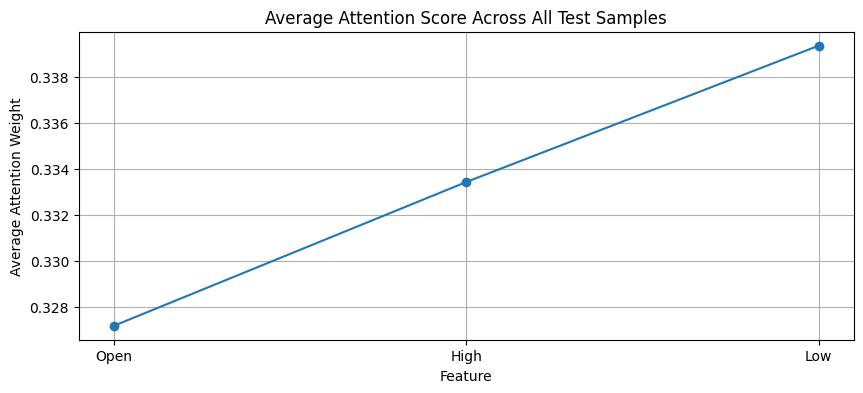

In [11]:
# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot(average_attention, marker='o')
plt.title("Average Attention Score Across All Test Samples")
plt.xlabel("Feature")
plt.ylabel("Average Attention Weight")
plt.xticks(ticks=[0, 1, 2], labels=['Open', 'High', 'Low'])
plt.grid(True)
plt.show()

# Now your turn, could you please have a look of the given model structure and find out how it works with attension?

In [ ]:
import configuration
from keras.utils import np_utils
from keras.layers import *
from keras.models import *
from keras.optimizers import Adam
from keras.regularizers import l2,l1
from keras.initializers import *


def attention_3d_block_f(inputs):
    # a = Permute((2, 1))(inputs)
    a = Dense(input_dim+1, activation='relu', use_bias=True)(inputs)
    a = Activation('softmax')(a)
    # a_probs = Permute((2, 1), name='attention_vec')(a)
    output_attention_mul = multiply([inputs, a], name='attention_mul')
    return output_attention_mul


def attention_3d_block_m(inputs):
    a = Permute((2, 1))(inputs)
    a = Dense(12, activation='relu', use_bias=True)(a)
    a = Activation('softmax')(a)
    a_probs = Permute((2, 1), name='attention_vec1')(a)
    output_attention_mul = multiply([inputs, a_probs], name='attention_mul1')
    return output_attention_mul
# build RNN model with attention

def buildmodel(train_x,train_y,test_x,test_y,dim1,dim2,dim3,dropout_1,batchsize,epoch):
    inputs2 = Input(shape=(12, dim1))
    attention_mul1 = attention_3d_block_f(inputs2)
    # attention_mul2 = attention_3d_block_m(inputs2)
    lstm_out2 = LSTM(dim2, return_sequences=False, activation='relu', dropout=0.01, kernel_initializer=he_normal(),
                     name='bilstm1')(
        attention_mul1)

    drop2 = Dropout(dropout_1)(lstm_out2)
    output1 = Dense(dim3, kernel_initializer=he_normal(), activation='relu')(drop2)
    output1 = Dense(1, kernel_initializer=he_normal())(output1)
    model2 = Model(inputs=inputs2, outputs=output1)
    model2.compile(loss='mape', optimizer='adam')
    #model2.summary()
    model2.fit(train_x,train_y, batch_size=batchsize, epochs=epoch, callbacks=cbks, verbose=1,
               validation_data=(test_x,test_y))
    return model2